# Open Mini-Challenge: Steuerdaten einer Gemeinde im Kanton Solothurn

## Bibliotheken importieren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

from helper import *

/Users/nicko/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Frage 1

**Erstellt eine Prognose der Steuererträge absolut und pro Person für die nächsten 10 Jahre unter Berücksichtigung allfälliger zyklischer Schwankungen aufgrund der historischen Steuererträge, ggf. in einer geeigneten Partition der Bevölkerung.**

### Daten einlesen und visualisieren

In [2]:
data = pd.read_csv('../Daten/Steuern_SO.csv', sep=';')
data.head()

,Jahr,Personen,Steuerbares Einkommen
0,1998,148329,6551307.0
1,1999,146773,6732949.0
2,2000,145022,6588062.0
3,2001,144154,7037941.0
4,2002,145781,7156045.0


Wir erstellen noch eine neue Spalte mit der Steuererträge pro Person.

In [3]:
data['Steuerbares Einkommen pro Person'] = round(data['Steuerbares Einkommen'] / data['Personen'],2)
data.describe()

,Jahr,Personen,Steuerbares Einkommen,Steuerbares Einkommen pro Person
count,21.000000,21.000000,2.100000e+01,21.000000
mean,2008.000000,157675.809524,7.963439e+06,50.387143
std,6.204837,11270.600541,8.973828e+05,2.701642
min,1998.000000,144154.000000,6.551307e+06,44.170000
25%,2003.000000,148329.000000,7.261471e+06,49.150000
50%,2008.000000,154909.000000,7.965942e+06,51.080000
75%,2013.000000,163634.000000,8.690159e+06,52.520000
max,2018.000000,177548.000000,9.293956e+06,54.450000


Die Daten enthalten Informationen für die Jahre 1998 bis 2018 und zeigen die Anzahl der Personen sowie das steuerbare Einkommen für jede dieser Jahre. Hier sind einige grundlegende statistische Informationen:

- Jahr: Die Daten umfassen einen Zeitraum von 21 Jahren (1998 bis 2018).

- Personen: Die Anzahl der Personen variiert im Laufe der Jahre mit einem Durchschnitt von etwa 157.676, wobei die niedrigste Anzahl bei 144.154 und die höchste bei 177.548 liegt.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt Schwankungen, mit einem durchschnittlichen Wert von etwa 7.963.439 CHF, einem Minimum von 6.551.307 CHF und einem Maximum von 9.293.956 CHF.

- Steuerbares Einkommen pro Person: Das steuerbare Einkommen pro Person zeigt ebenfalls Schwankungen, mit einem durchschnittlichen Wert von etwa 50.000 CHF, einem Minimum von 44.000 CHF und einem Maximum von 54.000 CHF.

Als nächstes sollten wir eine explorative Datenanalyse durchführen, um Trends, Muster und zyklische Schwankungen in den Daten zu identifizieren. Dies wird uns helfen, das am besten geeignete Modell für die Prognose auszuwählen. Wir können beispielsweise mit der Visualisierung der Zeitreihen für die Anzahl der Personen und das steuerbare Einkommen beginnen, um ein besseres Verständnis für die Daten zu bekommen. 

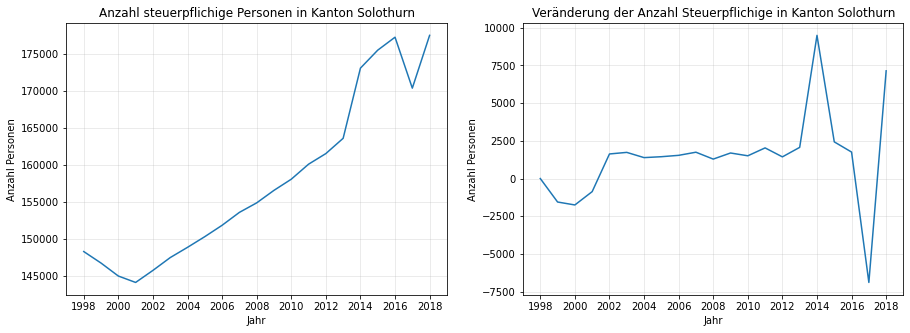

In [4]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Personen'],
    title1='Anzahl steuerpflichige Personen in Kanton Solothurn',
    title2='Veränderung der Anzahl Steuerpflichige in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Anzahl Personen',
    x_ticks = data['Jahr'][::2]
)

- Es ist interessant zu sehen, dass die Anzahl steuerpflichtige Personen in Kanton Solothurn im Jahr 2017 im Vergleich zu 2016 und 2018 viel tiefer ist.

- **Alternative Fragestellung**: Wann geschieht in Kanton Solothurn das nächste Mal ein Einbruch der Anzahl Steuerpflichtige wie im Jahr 2017?

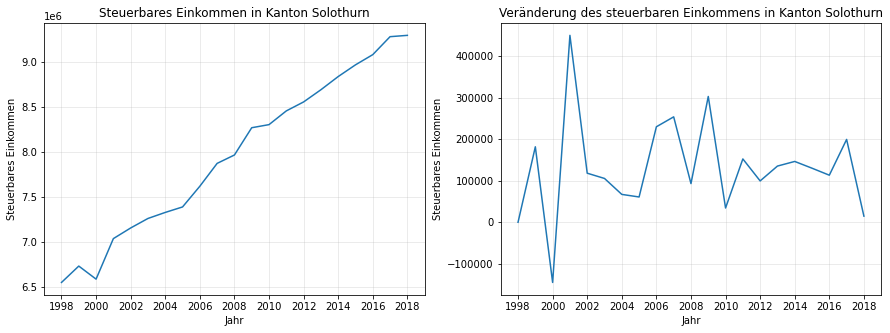

In [5]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Steuerbares Einkommen'],
    title1='Steuerbares Einkommen in Kanton Solothurn',
    title2='Veränderung des steuerbaren Einkommens in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Steuerbares Einkommen',
    x_ticks = data['Jahr'][::2]
)

- Anzahl der Personen: Es scheint einen allgemeinen Aufwärtstrend in der Anzahl der Personen über den betrachteten Zeitraum zu geben, mit einigen jährlichen Schwankungen.

- Steuerbares Einkommen: Das steuerbare Einkommen zeigt ebenfalls einen Aufwärtstrend, wobei es einige Jahre gibt, in denen das Einkommen besonders hoch oder niedrig ausfällt.

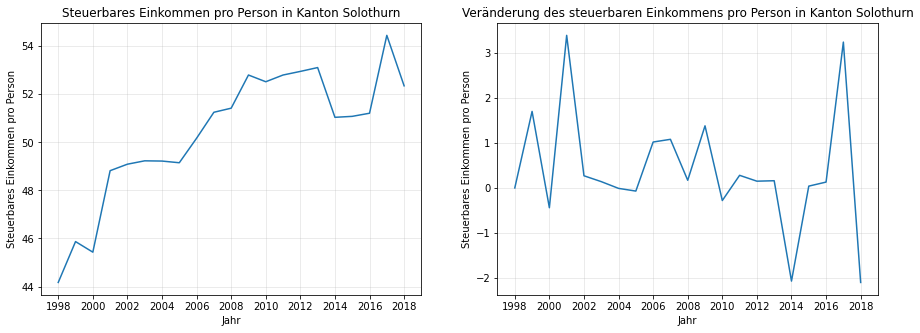

In [6]:
plot_lines(
    df=data,
    x=data['Jahr'],
    y=data['Steuerbares Einkommen pro Person'],
    title1='Steuerbares Einkommen pro Person in Kanton Solothurn',
    title2='Veränderung des steuerbaren Einkommens pro Person in Kanton Solothurn',
    xlabel='Jahr',
    ylabel='Steuerbares Einkommen pro Person',
    x_ticks = data['Jahr'][::2]
)

Für die Prognose der Steuererträge für die nächsten 10 Jahre müssen wir ein Modell auswählen, das sowohl mit Trends als auch mit zyklischen Schwankungen umgehen kann. Basierend auf diesen Beobachtungen könnten wir Modelle wie ARIMA (Autoregressive Integrated Moving Average) oder SARIMA (Seasonal ARIMA) in Betracht ziehen, die für trendabhängige Zeitreihendaten geeignet sind.

Bevor wir das Modell auswählen und trainieren, sollten wir auch überprüfen, ob es notwendig ist, die Daten zu transformieren oder zu differenzieren, um eine Stationarität zu erreichen, was ein wichtiger Schritt bei der Anwendung dieser Modelle ist.

### Test auf Stationarität

Um die Stationarität der Zeitreihendaten zu überprüfen, werden wir statistische Tests anwenden, wie z. B. den Augmented Dickey-Fuller-Test (ADF-Test), um die Nullhypothese zu überprüfen, dass die Zeitreihe eine Einheitswurzel hat und somit nicht stationär ist.

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 -4.003652
p-value                         0.001392
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


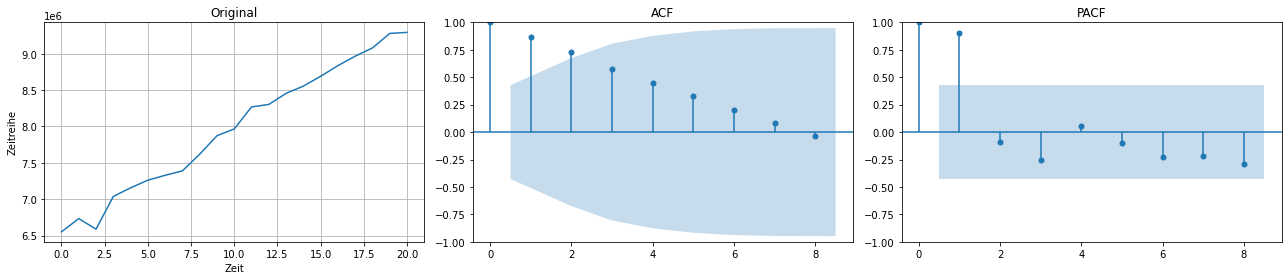

In [7]:
test_stationarity(data['Steuerbares Einkommen'], lags=8)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                  1.482979
p-value                         0.997460
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


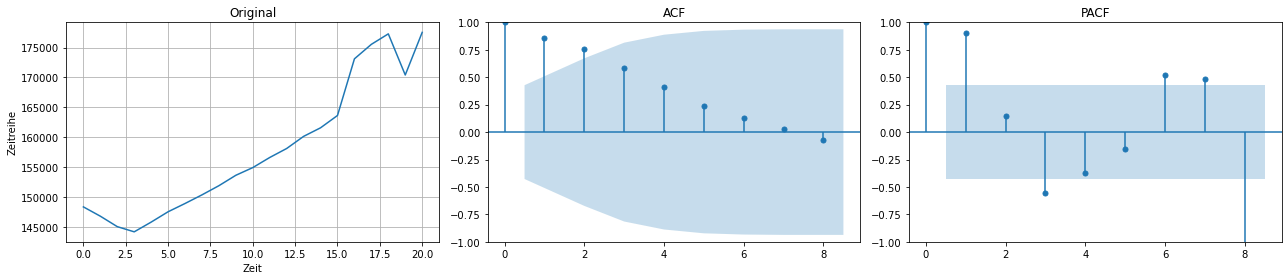

In [8]:
test_stationarity(data['Personen'], lags=8)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 -2.499048
p-value                         0.115706
#Lags Used                      0.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


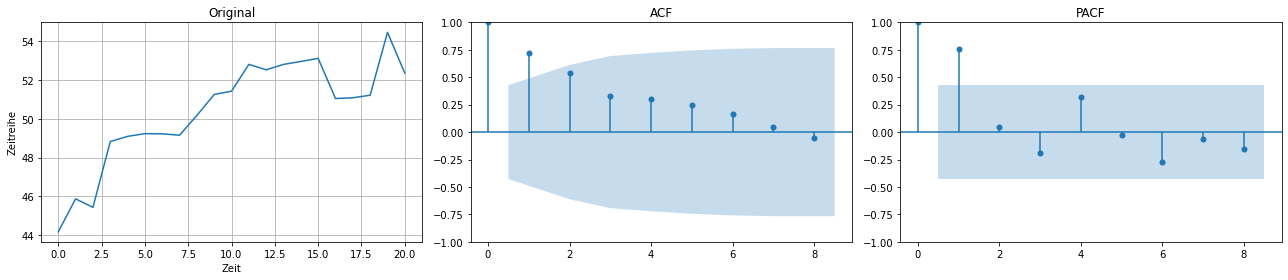

In [9]:
test_stationarity(data['Steuerbares Einkommen pro Person'], lags=8)

#### Interpretation
- Für das steuerbare Einkommen ist der p-Wert niedrig (0.0014). Diese Zeitreihe ist sehr wahrscheinlich stationär.
- Für die Anzahl der Personen ist der p-Wert sehr hoch (0.9975), was bedeutet, dass wir die Nullhypothese der Nicht-Stationarität nicht ablehnen können. Die Zeitreihe ist wahrscheinlich nicht stationär.
- Für das steuerbare Einkommen pro Person ist der p-Wert 0.116, was bedeutet, dass wir die Nullhypothese der Nicht-Stationarität nicht ablehnen können. Die Zeitreihe ist wahrscheinlich nicht stationär.

#### Nächste Schritte
- Für das steuerbare Einkommen scheint keine weitere Transformation notwendig zu sein, da die Zeitreihe bereits stationär zu sein scheint.
- Für die Zeitreihe der Anzahl der Personen und des steuerbaren Einkommens pro Person sollten wir eine Differenzierung oder eine andere Transformation (wie Logarithmus) in Betracht ziehen, um Stationarität zu erreichen.

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 -1.363827
p-value                         0.599490
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


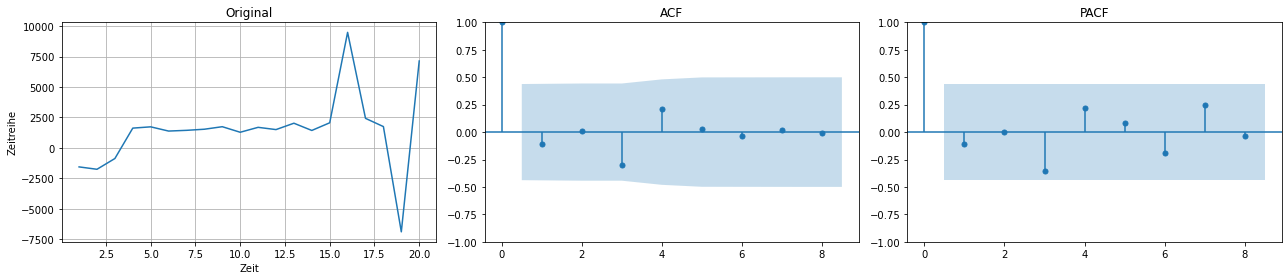

In [10]:
test_stationarity(data['Personen'].diff().dropna(), lags=8)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 -5.568082
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


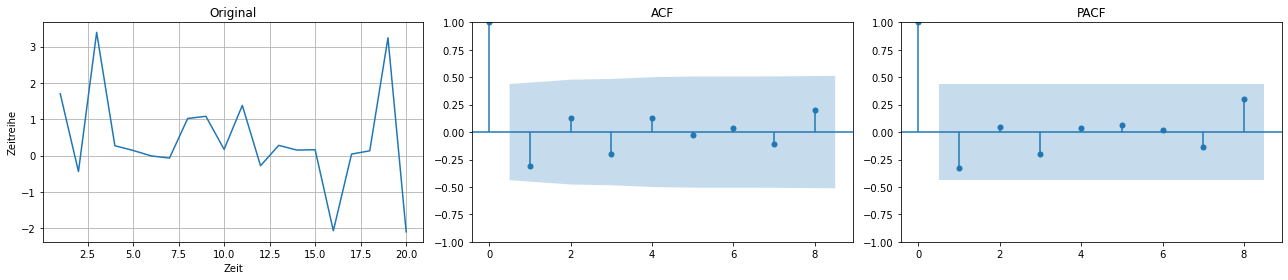

In [11]:
test_stationarity(data['Steuerbares Einkommen pro Person'].diff().dropna(), lags=8)

Die Spalte `Steuerbares Einkommen pro Person` scheint anhand des p-Wertes nach der Differezierung stationär zu sein. Wir müssen daher keine andere Transformation in Betracht ziehen, wie z.B. die Anwendung des Logarithmus.

Da die Spalte `Personen` basierend auf dem p-Wert nach der Differenzierung immer noch nicht stationär ist, werden wir die Anwendung des Logarithmus und Dekomposition in Betracht ziehen.

Eine logarithmische Transformation ist eine gängige Methode zur Stabilisierung der nicht-stationären Varianz. Diese Transformation ist besonders effektiv, wenn es sich um Daten handelt, die ein exponentielles Wachstum aufweisen, oder wenn die Grösse der Daten im Laufe der Zeit zunimmt, was beispielsweise bei Bevölkerungsstudien häufig der Fall ist. Durch die Transformation der Daten mit Hilfe des natürlichen Logarithmus können wir eventuell die Varianz stabilisieren und die Daten näher an die Stationarität heranführen. 

Es ist jedoch wichtig zu beachten, dass jede Transformation mit einem Verständnis für die Daten und ihren Bereich angewendet werden sollte. 

Da `Personen` die Anzahl der Menschen ist und die Anzahl im Laufe der Zeit aufgrund des natürlichen Wachstums exponentiell gestiegen ist, wäre eine Logarithmentransformation theoretisch gerechtfertigt. Die transformierten Daten würden dann die relativen Veränderungen und Wachstumsraten widerspiegeln und nicht die absoluten Veränderungen der Bevölkerungszahlen.

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                  1.542819
p-value                         0.997675
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


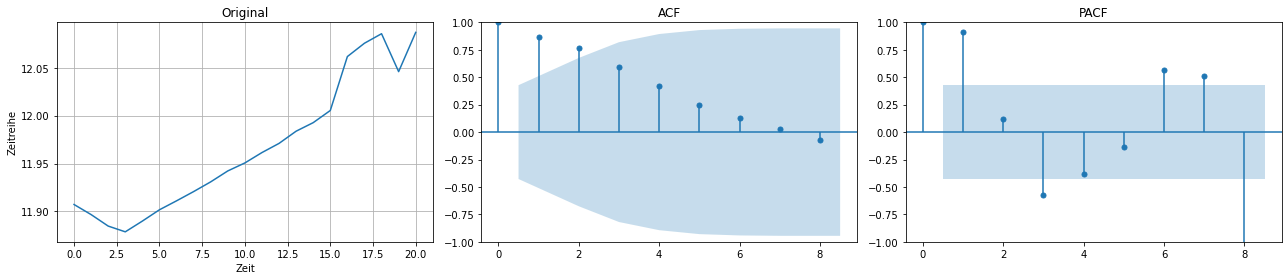

In [12]:
test_stationarity(np.log(data['Personen']).dropna(), lags=8)

- Die Log-Transformation der Anzahl Personen ist weiter weg von der Stationarität als die Differenzierung. Wir werden nun die Dekomposition anwenden.

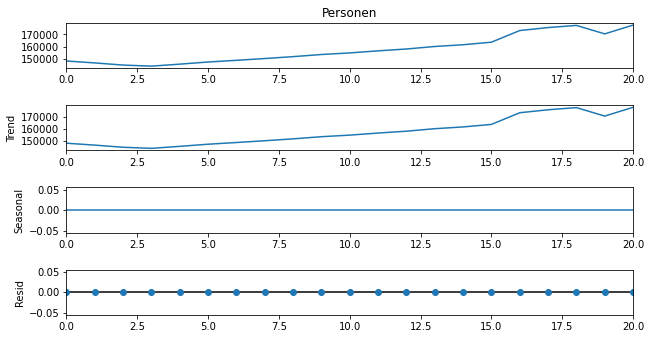

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Personen'], period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 5)
plt.show()

Anhand der Diagramme allein lässt sich nicht endgültig feststellen, ob die Daten stationär sind, aber wir können einige qualitative Bewertungen vornehmen. Die Trendkomponente scheint einen klaren Aufwärtstrend aufzuweisen, was auf Nicht-Stationarität hindeutet. Es scheint keine ausgeprägte saisonale Komponente zu geben, weil der pro Jahr nur 1 Datenpunkt beinhaltet. Das bedeutet, dass die Saisonabhängigkeit kein bedeutender Faktor ist. Die Residuen sind auch alle 0, auch weil es nur 1 Datenpunkt pro Jahr gibt.

### Autokorrelationen

Bestimmung der ARIMA-Parameter ($p$, $d$, $q$):
- $p$: Anzahl der Lag-Observationen im Modell (Autoregression).
- $d$: Grad der Differenzierung.
- $q$: Grösse des gleitenden Durchschnittsfensters (Moving Average).

#### Steuerbares Einkommen

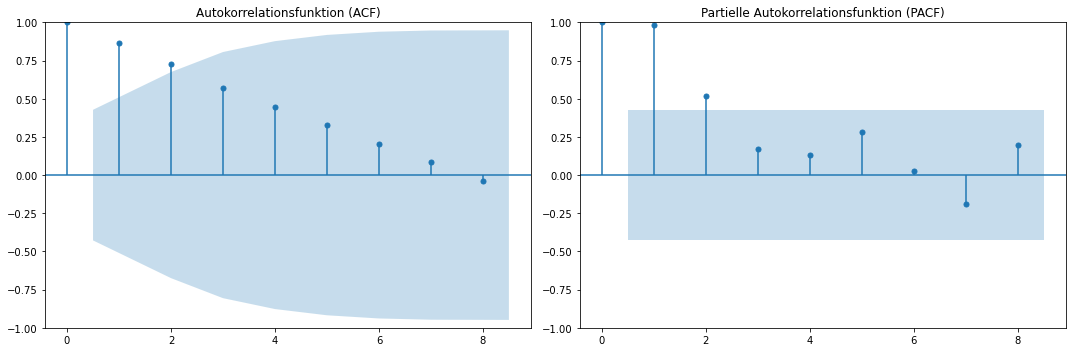

In [14]:
plot_acf_pacf(data['Steuerbares Einkommen'], lags=8)

Die ACF und PACF für die Zeitreihe des steuerbaren Einkommens wurden mit 8 Lags erfolgreich berechnet und dargestellt. Diese Plots helfen uns, die geeigneten Parameter für das ARIMA-Modell zu bestimmen:

**Parameter \( $p$ \) (AR-Teil)**: 
- Bestimmt durch die Anzahl der signifikanten Spitzen im PACF-Diagramm -> 3.
- Eine signifikante Spitze im PACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( p \) mindestens \( k \) sein könnte.

**Parameter \( $d$ \) (Differenzierung)**:
- Da wir bereits festgestellt haben, dass die Zeitreihe des steuerbaren Einkommens stationär ist, ist der Differenzierungsgrad \( d \) wahrscheinlich 0. Da wir trotzdem vorsichtig vorgehen möchten, werden wir \( d \) auf 1 setzen.

**Parameter \( $q$ \) (MA-Teil)**:
- Bestimmt durch die Anzahl der signifikanten Spitzen im ACF-Diagramm -> 3.
- Eine signifikante Spitze im ACF-Diagramm bei Lag \( k \) deutet darauf hin, dass \( q \) mindestens \( k \) sein könnte.

Parameter für das Modell: \( $p$ \) = 3, \( $d$ \) = 1, \( $q$ \) = 3

Wenn hier der Trend nicht dominieren würde, sähen wir hier nur zwei signifikante Lags in der ACF und PACF (Lag=0 zählt nicht, und bei Lag=1 sind ACF und PACF identisch)

#### Steuerbares Einkommen pro Person

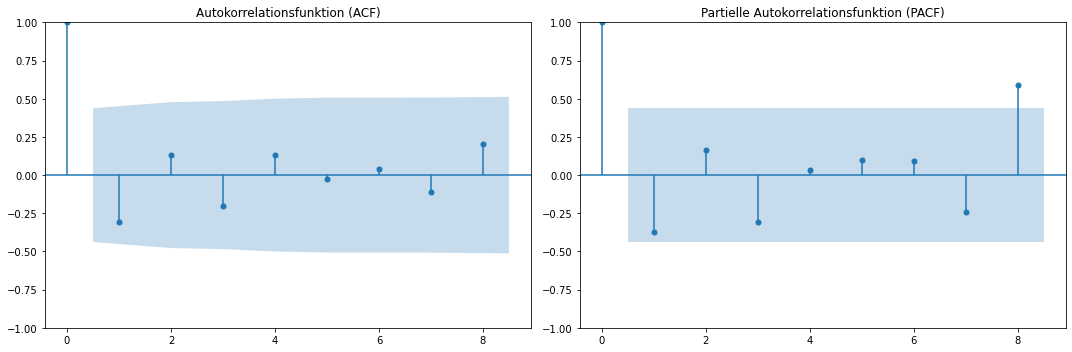

In [15]:
plot_acf_pacf(data['Steuerbares Einkommen pro Person'].diff().dropna(), lags=8)

Wir können hier ebenfalls die Parameter für das Modell herauslesen: \( $p$ \) = 3, \( $d$ \) = 1, \( $q$ \) = 2

Da diese Werte auf eine Überparameterisierung hindeuten, werden wir später andere Methoden verwenden, um die Parameter zu bestimmen und das Modell zu vereinfachen.

### ARIMA-Modell (Steuerbares Einkommen)

Aus der vorherigen Aufgabe haben wir die Parameter für das ARIMA-Modell aus den Plots herausgelesen. Wir haben aber auch noch eine Funktion erstellt, die uns automatisch die besten Parameter für das ARIMA-Modell basierend auf dem Akaike-Informationskriterium (AIC) bestimmt. 

Wir werden diese Funktion nun anwenden.

In [16]:
best_order, best_model = find_best_arima(data['Steuerbares Einkommen'])
print(f"Best ARIMA order: {best_order}")
print(best_model.summary())

Best ARIMA order: (2, 1, 2)
                                 SARIMAX Results                                 
Dep. Variable:     Steuerbares Einkommen   No. Observations:                   21
Model:                    ARIMA(2, 1, 2)   Log Likelihood                -257.929
Date:                   Wed, 03 Jan 2024   AIC                            525.858
Time:                           14:17:23   BIC                            530.837
Sample:                                0   HQIC                           526.830
                                    - 21                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1260      0.067      1.882      0.060      -0.005       0.257
ar.L2          0.8677      0.067     12.941      0.000       0.736       0.999


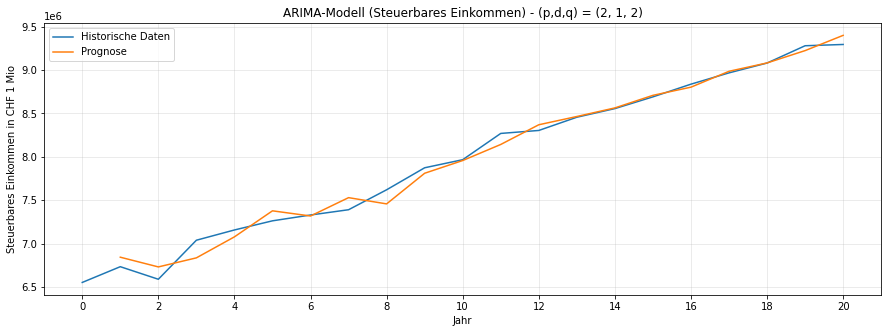

In [17]:
# Festlegen der ARIMA-Modellparameter
p, d, q = best_order

# Trainieren des ARIMA-Modells
arima_result = arima_model(data['Steuerbares Einkommen'], p, d, q)

# Plotten des ARIMA-Modells
plot_arima_model(
    data['Steuerbares Einkommen'], 
    arima_result, 
    'ARIMA-Modell (Steuerbares Einkommen) - (p,d,q) = {}'.format(best_order),
    'Steuerbares Einkommen in CHF 1 Mio'
)

- Historische Daten: Dargestellt durch die blaue Linie, zeigt die tatsächlichen Werte des steuerbaren Einkommens über die Zeit.

- Prognose/Fitted Values: Dargestellt durch die orange Linie, zeigt die vom ARIMA-Modell angepassten Werte oder Prognosen, die auf den historischen Daten basieren.

Die Fitted Values werden vom ARIMA-Modell generiert und sollen so nah wie möglich an den historischen Daten liegen. Sie repräsentieren, was das Modell basierend auf seiner Struktur (den Parametern $p$, $d$ und $q$) und den ihm gegebenen Daten als den zugrunde liegenden Prozess erkennt.

Wir sehen, dass die Fitted Values die historischen Daten gut abbilden, was bedeutet, dass das Modell die Daten gut erfasst hat. Dies ist ein gutes Zeichen dafür, dass das Modell auch für die Prognose gut funktionieren sollte.

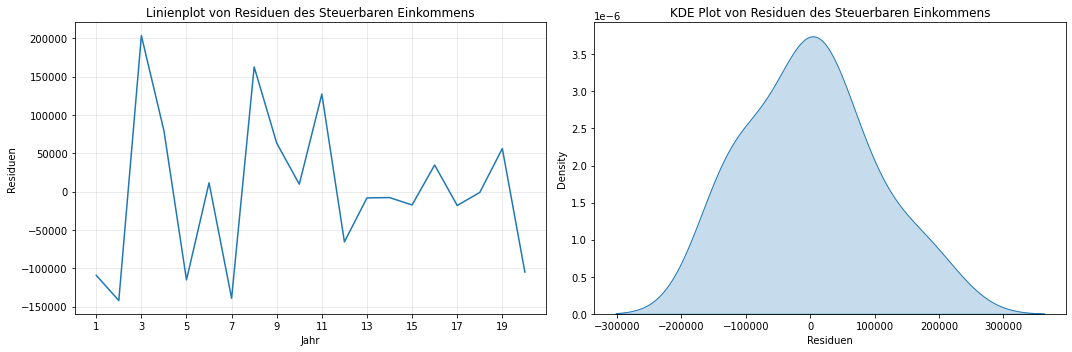

In [18]:
residuals_arima = arima_result.resid[1:]
plot_residuals(residuals_arima, 'Residuen des Steuerbaren Einkommens')

- Zeitreihendiagramm der Residuen: Hier suchen wir nach Mustern oder Trends. Idealerweise sollten die Residuen keine erkennbaren Muster aufweisen und um den Nullwert herum verteilt sein. In diesem Fall scheinen die Residuen relativ zufällig verteilt zu sein, was gut ist.

- KDE Plot der Residuen: Dieses Diagramm hilft uns zu beurteilen, ob die Residuen normalverteilt sind, was ein weiteres Zeichen für ein gut angepasstes Modell wäre. Das Histogramm zeigt eine recht symmetrische Verteilung um den Mittelwert, was darauf hindeutet, dass die Annahme der Normalverteilung der Residuen nicht verletzt wird.

### Trend Modell (Steuerbares Einkommen)

Da die ARIMA-Modelle "out of the box" meistens überparametrisiert sind, und die Vorhersagen von ARIMA allein oft enttäuschend sind, werden wir nun ein einfacheres Modell verwenden, um die Vorhersage zu verbessern. Wir werden ein Modell mit einem deterministischen Trend verwenden.

Danach führen wir ein stochastisches Modell der Residuen durch und dies würde zeigen, ob noch etwas Struktur über die Zeit hinweg übrigbleibt.

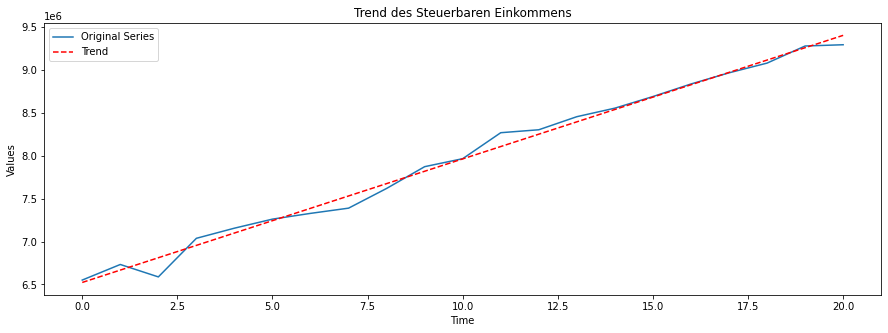

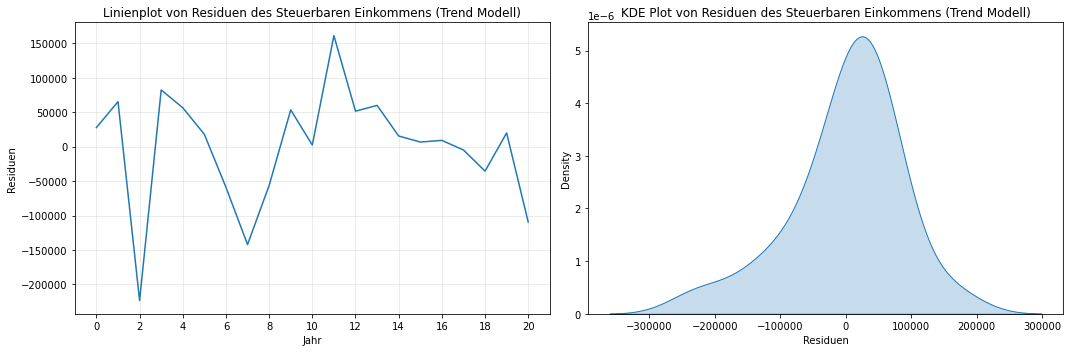

In [19]:
trend, trend_residuals, trend_model = fit_trend_model(data['Steuerbares Einkommen'])

plot_trend(data['Steuerbares Einkommen'], trend, 'Trend des Steuerbaren Einkommens')
plot_residuals(trend_residuals, 'Residuen des Steuerbaren Einkommens (Trend Modell)')

#### Stochastisches Modell der Residuen

- ARIMA-Modell an die Residuen fitten.
- Modell prüfen, ob die Residuen dieses neuen Modells weisses Rauschen sind, was auf eine gute Anpassung hindeuten würde.
- Statistische Metriken wie das AIC (Akaike Information Criterion) verwenden, um verschiedene ARIMA-Modelle zu vergleichen und das beste Modell auszuwählen.

In [20]:
# Check if the residuals of the trend model are stationary
check_stationarity(trend_residuals)

# If residuals are not stationary, fit a conservative ARIMA model
if adfuller(trend_residuals)[1] >= 0.05:
    p_values = range(0, 2)  # More conservative range
    d_values = range(0, 2)
    q_values = range(0, 2)
    best_order, best_model = find_best_arima(trend_residuals)
    print(f"Best ARIMA order for residuals: {best_order}")
    print(best_model.summary())
else:
    print("Kein ARIMA-Modell erforderlich für Residuen.")

ADF Statistic: -2.075119235697758
p-value: 0.25463623834407034
Critial Values: 1%, -4.137829282407408
Critial Values: 5%, -3.1549724074074077
Critial Values: 10%, -2.7144769444444443
Die Residuen sind nicht stationär und könnten von einem ARIMA-Modell profitieren.
Best ARIMA order for residuals: (0, 1, 1)
                                 SARIMAX Results                                 
Dep. Variable:     Steuerbares Einkommen   No. Observations:                   21
Model:                    ARIMA(0, 1, 1)   Log Likelihood                -256.673
Date:                   Wed, 03 Jan 2024   AIC                            517.346
Time:                           14:17:24   BIC                            519.338
Sample:                                0   HQIC                           517.735
                                    - 21                                         
Covariance Type:                     opg                                         
                 coef    std err     

ARIMA(0, 1, 1) Modell: Dieses Modell ist relativ einfach und zeigt an, dass die Differenzierung erster Ordnung (d=1) notwendig ist, um die Stationarität der Residuen zu erreichen. Das Modell enthält keinen autoregressiven Term (p=0) und einen Moving Average Term erster Ordnung (q=1). Zusammenfassend haben wir mittels Residuen des Trend-Modells ein vereinfachtes ARIMA-Modell gefunden, das die Daten gut abbildet.

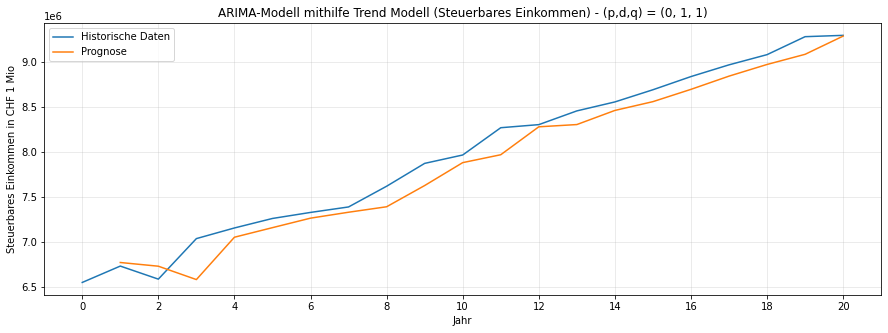

In [21]:
p, d, q = best_order

arima_result = arima_model(data['Steuerbares Einkommen'], p, d, q)

plot_arima_model(
    data['Steuerbares Einkommen'], 
    arima_result, 
    'ARIMA-Modell mithilfe Trend Modell (Steuerbares Einkommen) - (p,d,q) = {}'.format(best_order),
    'Steuerbares Einkommen in CHF 1 Mio'
)

**Interpretation der Plots**

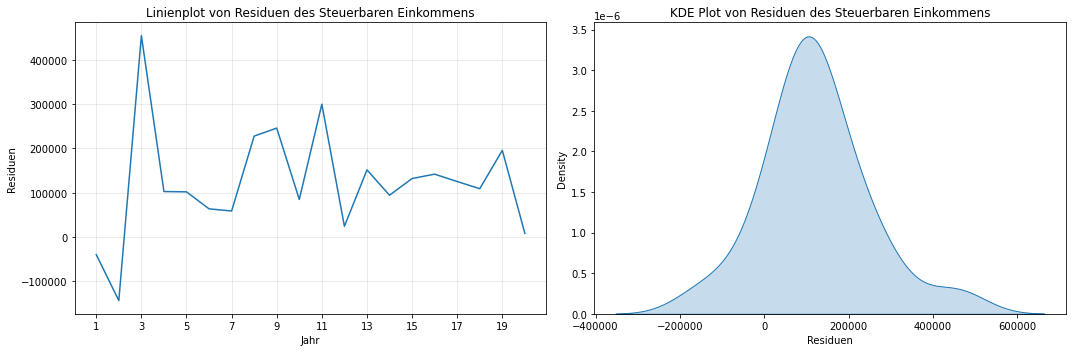

In [22]:
residuals_arima = arima_result.resid[1:]
plot_residuals(residuals_arima, 'Residuen des Steuerbaren Einkommens')

**Interpretation der Plots**

#### Trend Modell (Steuerbares Einkommen pro Person)

Für das Steuerbares Einkommen pro Person werden wir ein ähnliches Vorgehen anwenden. Wir werden ein ARIMA-Modell an die Residuen des Trend-Modells fitten. Danach werden wir statistische Metriken wie das AIC (Akaike Information Criterion) verwenden, um verschiedene ARIMA-Modelle zu vergleichen und das beste Modell auszuwählen.

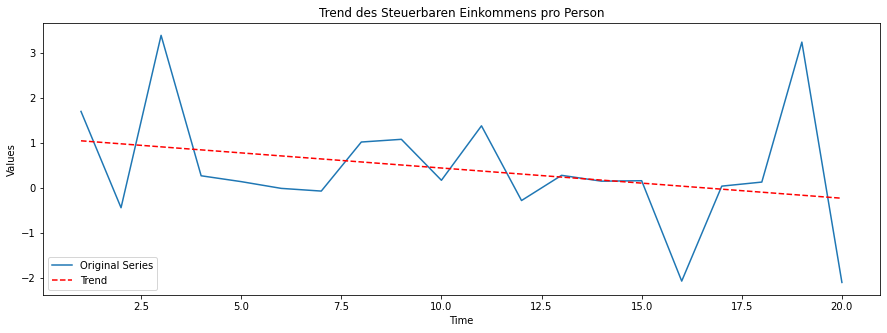

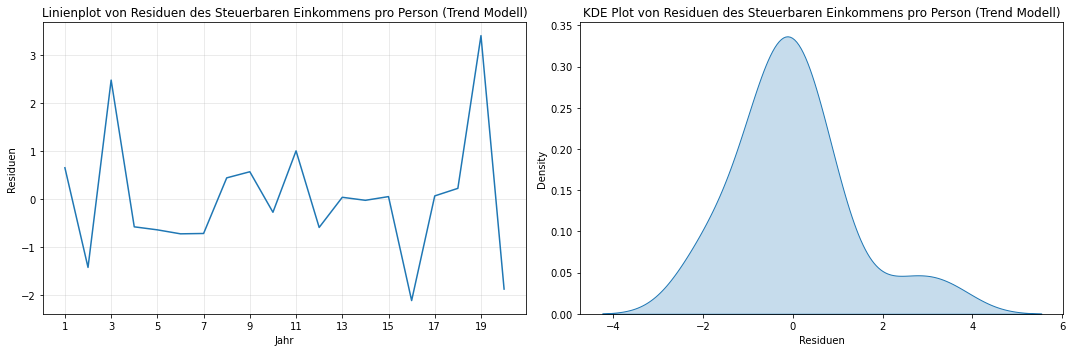

In [23]:
trend, trend_residuals, trend_model = fit_trend_model(data['Steuerbares Einkommen pro Person'].diff().dropna())

plot_trend(data['Steuerbares Einkommen pro Person'].diff().dropna(), trend, 'Trend des Steuerbaren Einkommens pro Person')
plot_residuals(trend_residuals, 'Residuen des Steuerbaren Einkommens pro Person (Trend Modell)')

**Interpretation der Plots**

#### Stochastisches Modell der Residuen

In [24]:
# Check if the residuals of the trend model are stationary
check_stationarity(trend_residuals)

# If residuals are not stationary, fit a conservative ARIMA model
if adfuller(trend_residuals)[1] >= 0.05:
    p_values = range(0, 2)  # More conservative range
    d_values = range(0, 2)
    q_values = range(0, 2)
    best_order, best_model = find_best_arima(trend_residuals)
    print(f"Best ARIMA order for residuals: {best_order}")
    print(best_model.summary())
else:
    print("Kein ARIMA-Modell erforderlich für Residuen.")

ADF Statistic: -2.1854129906050863
p-value: 0.2115822321029937
Critial Values: 1%, -4.223238279489106
Critial Values: 5%, -3.189368925619835
Critial Values: 10%, -2.729839421487603
Die Residuen sind nicht stationär und könnten von einem ARIMA-Modell profitieren.
Best ARIMA order for residuals: (0, 0, 1)
                                      SARIMAX Results                                       
Dep. Variable:     Steuerbares Einkommen pro Person   No. Observations:                   20
Model:                               ARIMA(0, 0, 1)   Log Likelihood                 -29.191
Date:                              Wed, 03 Jan 2024   AIC                             64.383
Time:                                      14:17:25   BIC                             67.370
Sample:                                           0   HQIC                            64.966
                                               - 20                                         
Covariance Type:                            

Die Funktion gibt uns die Parameter \( $p$ \) = 0, \( $d$ \) = 0, \( $q$ \) = 1 zurück.

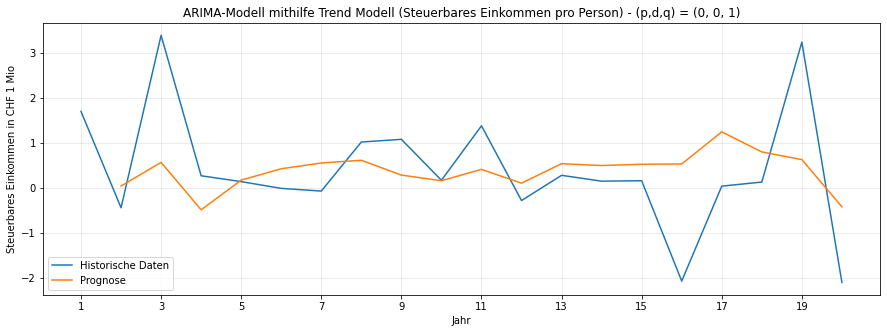

In [25]:
p, d, q = best_order

arima_result_2 = arima_model(data['Steuerbares Einkommen pro Person'].diff().dropna(), p, d, q)

plot_arima_model(
    data['Steuerbares Einkommen pro Person'].diff().dropna(), 
    arima_result_2, 
    'ARIMA-Modell mithilfe Trend Modell (Steuerbares Einkommen pro Person) - (p,d,q) = {}'.format(best_order),
    'Steuerbares Einkommen in CHF 1 Mio'
)

**Interpretation der Plots**

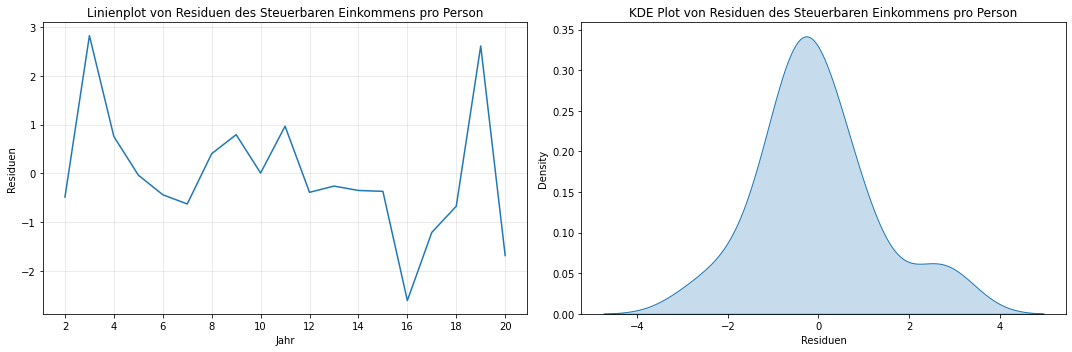

In [26]:
residuals_arima_2 = arima_result_2.resid[1:]
plot_residuals(residuals_arima_2, 'Residuen des Steuerbaren Einkommens pro Person')

### Vorhersagen
#### Steuerbares Einkommen

Für die Vorhersagen, werden wir die Parameter des automatischen ARIMA-Modells verwenden. Wir werden die Vorhersagen für die nächsten 10 Jahre machen.

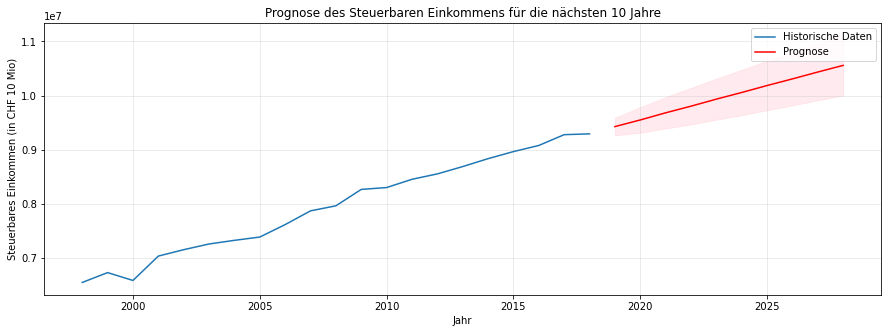

In [27]:
arima_result = arima_model(data['Steuerbares Einkommen'], 2, 1, 2)

residuals_arima = arima_result.resid[1:]

prognose_start, prognose_ende, prognose_mean, prognose_conf_int = get_predictions(10, arima_result, data)

# Visualisierung der Prognose zusammen mit den historischen Daten
plt.figure(figsize=(15, 5))
plt.plot(data['Jahr'], data['Steuerbares Einkommen'], label='Historische Daten')
plt.plot(range(prognose_start, prognose_ende + 1), prognose_mean, label='Prognose', color='red')
plt.fill_between(range(prognose_start, prognose_ende + 1), prognose_conf_int.iloc[:, 0], prognose_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prognose des Steuerbaren Einkommens für die nächsten 10 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen (in CHF 10 Mio)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Die Prognose des steuerbaren Einkommens für die nächsten 10 Jahre wurde erfolgreich erstellt und ist im obigen Diagramm dargestellt. In der Grafik sieht man:

- Historische Daten: Die blaue Linie zeigt das steuerbare Einkommen der vergangenen Jahre.

- Prognose: Die rote Linie repräsentiert die prognostizierten Werte des steuerbaren Einkommens für die nächsten 10 Jahre.

- Konfidenzintervall: Der rosafarbene Bereich zeigt das 95% Konfidenzintervall der Prognose. Dies gibt den Bereich an, in dem die tatsächlichen Werte mit einer Wahrscheinlichkeit von 95% liegen sollten.

- Da das Modell einfach ist und nicht überangepasst wurde, ist das Konfidenzintervall relativ breit.

#### Steuerbares Einkommen pro Person

Wie bei den Vorhersagen für das steuerbare Einkommen, werden wir die Parameter des automatischen ARIMA-Modells verwenden:

In [28]:
best_order, best_model = find_best_arima(data['Steuerbares Einkommen pro Person'].diff().dropna())
print(f"Best ARIMA order: {best_order}")
print(best_model.summary())

Best ARIMA order: (1, 0, 0)
                                      SARIMAX Results                                       
Dep. Variable:     Steuerbares Einkommen pro Person   No. Observations:                   20
Model:                               ARIMA(1, 0, 0)   Log Likelihood                 -32.717
Date:                              Wed, 03 Jan 2024   AIC                             71.434
Time:                                      14:17:26   BIC                             74.421
Sample:                                           0   HQIC                            72.017
                                               - 20                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4260      0.215      1.982      0.047       0.005    

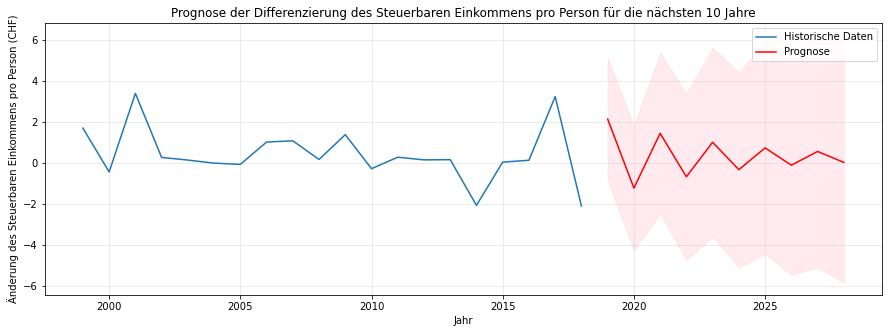

In [29]:
arima_result_2 = arima_model(data['Steuerbares Einkommen pro Person'].diff().dropna(), 1, 1, 0)

residuals_arima_2 = arima_result_2.resid[1:]

prognose_start, prognose_ende, prognose_mean, prognose_conf_int = get_predictions(10, arima_result_2, data)

# Visualisierung der Prognose zusammen mit den historischen Daten
plt.figure(figsize=(15, 5))
plt.plot(data['Jahr'][1:], data['Steuerbares Einkommen pro Person'].diff().dropna(), label='Historische Daten')  # Start from the second year to align with the differenced data
plt.plot(range(prognose_start, prognose_ende + 1), prognose_mean, label='Prognose', color='red')
plt.fill_between(range(prognose_start, prognose_ende + 1), prognose_conf_int.iloc[:, 0], prognose_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prognose der Differenzierung des Steuerbaren Einkommens pro Person für die nächsten 10 Jahre')
plt.xlabel('Jahr')
plt.ylabel('Änderung des Steuerbaren Einkommens pro Person (CHF)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Dasselbe gilt bei den Vorhersagen der Differenzierung des steuerbaren Einkommens pro Person. Das Konfidenzintervall ist sehr breit, was auf die Einfachheit des Modells zurückzuführen ist.

### Extremwertanalyse

Die Extremwertanalyse ist ein statistischer Ansatz, um die Verteilung von Werten am äussersten Ende des Spektrums zu untersuchen, was besonders wichtig ist, wenn man sich für das Risiko von seltenen Ereignissen interessiert, wie z.B. in der Finanzrisikoanalyse oder bei der Bewertung von Naturkatastrophen.

#### Shapiro Wilk Test & QQ Plot

Ein Q-Q-Plot stellt die Quantile der Residuenverteilung denen einer Normalverteilung gegenüber. Die Residuenverteilung ist normalverteilt, wenn die Punkte auf einer geraden Linie liegen.

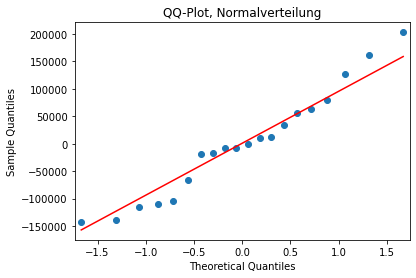

Shapiro-Wilk Test: Statistik=0.9574923515319824, p-Wert=0.4950511157512665


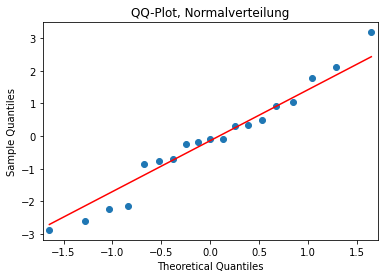

Shapiro-Wilk Test: Statistik=0.9705061912536621, p-Wert=0.786540150642395


In [30]:
from scipy.stats import shapiro

def plot_qq_and_evaluate(residuals):
    fig = qqplot(residuals, line='s')
    plt.title('QQ-Plot, Normalverteilung')
    plt.show()

    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk Test: Statistik={shapiro_test[0]}, p-Wert={shapiro_test[1]}")

plot_qq_and_evaluate(residuals_arima)
plot_qq_and_evaluate(residuals_arima_2)

Der Output des Shapiro-Wilk-Tests liefert zwei wichtige Informationen:

Teststatistik: Dieser Wert misst, wie gut die Daten einer Normalverteilung entsprechen. Werte nahe 1 deuten auf eine gute Übereinstimmung mit einer Normalverteilung hin.

p-Wert: Der p-Wert zeigt an, ob man die Nullhypothese ablehnen kann oder nicht. In der Regel wird ein Schwellenwert (Alpha-Wert) von 0.05 verwendet. Ist der p-Wert grösser als 0.05, können man nicht davon ausgehen, dass die Daten signifikant von einer Normalverteilung abweichen.

In unserem Fall liegt der p-Wert über 0.05, was bedeutet, dass wir nicht davon ausgehen können, dass die Residuen signifikant von einer Normalverteilung abweichen. Es gibt keinen starken Grund zu der Annahme, dass die Residuen nicht normalverteilt sind.

Kurtosis: -0.5472651608882328, Schiefe: 0.3167364434493139


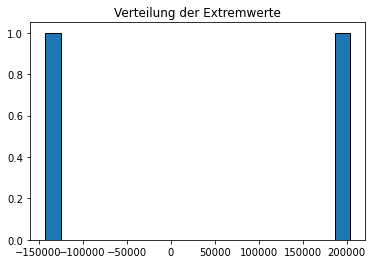

Kurtosis: -0.4041996283162783, Schiefe: 0.0661789959978405


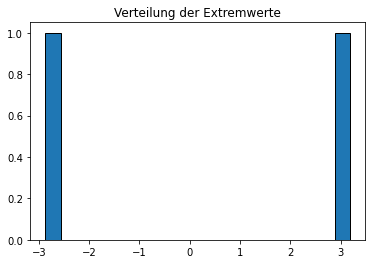

In [31]:
from scipy.stats import kurtosis, skew

# Kurtosis und Schiefe
def plot_edges(residuals):
    kurt = kurtosis(residuals)
    skw = skew(residuals)
    print(f"Kurtosis: {kurt}, Schiefe: {skw}")

    # Schwellenwert-basierte Analyse
    upper_threshold = np.quantile(residuals, 0.95)
    lower_threshold = np.quantile(residuals, 0.05)
    extreme_values = residuals[(residuals > upper_threshold) | (residuals < lower_threshold)]

    plt.hist(extreme_values, bins=20, edgecolor='black')
    plt.title('Verteilung der Extremwerte')
    plt.show()

plot_edges(residuals_arima)
plot_edges(residuals_arima_2)

Die Plots und die Werte deuten auf keine grossen Ausreisser hin. Wie bereits erklärt, hängt es mit dem zu kleinen Datensatz zusammen.

#### Histogramm und Normalverteilung

Ein Histogramm zeigt die Häufigkeitsverteilung der Residuen. Die Überlagerung der Wahrscheinlichkeitsdichtefunktion einer Normalverteilung gibt an, wie gut die Residuen dieser Verteilung folgen.

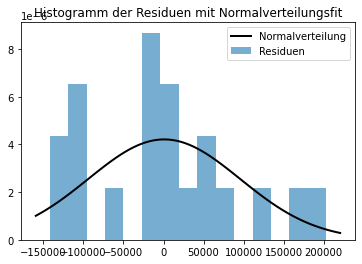

In [32]:
# Histogramm der Residuen des Steuerbaren Einkommens
plot_residuals_histogram(residuals_arima, 15)

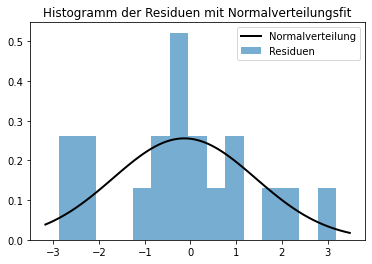

In [33]:
# Histogramm der Residuen des Steuerbaren Einkommens pro Person
plot_residuals_histogram(residuals_arima_2, 15)

#### Kumulative Verteilungsfunktion (CDF)

Sie vergleicht die empirische kumulative Verteilungsfunktion der Residuen mit der kumulativen Verteilungsfunktion einer Normalverteilung. Die Residuen sollten der Normalverteilung folgen, wenn die Punkte auf der diagonalen Linie liegen.

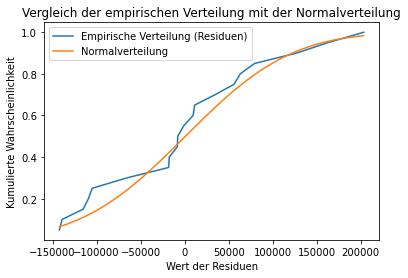

In [34]:
# ECDF der Residuen von Steuerbares Einkommen
plot_residuals_ecdf(residuals_arima)

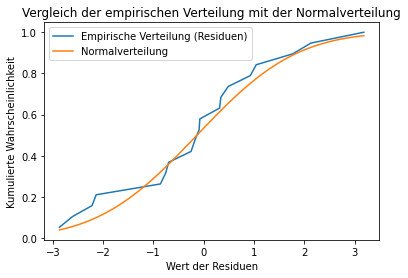

In [35]:
# ECDF der Residuen von Steuerbares Einkommen pro Person
plot_residuals_ecdf(residuals_arima_2)

## Frage 2

**Bestimmt, wie stark BIP- und Demographiezahlen als vorlaufende Indikatoren verwendbar sind, wie viele Jahre Vorlauf sie Euch gewähren.**

In [36]:
bip_df = pd.read_csv('../Daten/BIP_SO.csv', sep=';')
bev_df = pd.read_csv('../Daten/Bevölkerung_SO_Neu.csv', sep=';')

In [37]:
steuern_df = data.copy()

# Convert to datetime
steuern_df['Jahr'] = pd.to_datetime(steuern_df['Jahr'], format='%Y')
bip_df['Jahr'] = pd.to_datetime(bip_df['Jahr'], format='%Y')
bev_df['Jahr'] = pd.to_datetime(bev_df['Datum']).dt.to_period('Y').dt.to_timestamp()

# Remove unnecessary column 'Datum' in bev_df
bev_df.drop(columns=['Datum'], inplace=True)

# Merge dataframes
df = pd.merge(steuern_df, bip_df, on='Jahr', how='outer')
df = pd.merge(df, bev_df, on='Jahr', how='outer')

# Sort by 'Jahr' and remove rows with missing values
df.sort_values(by='Jahr', inplace=True)
df.dropna(inplace=True)

df.head()

,Jahr,Personen,Steuerbares Einkommen,Steuerbares Einkommen pro Person,BIP_SO,BIP_NWCH,BIP_CH,KT_SO,Sonnenberg
10,2008-01-01,154909.0,7965942.000,51.42,16764.66925,88564.12220,614407.7193,254444,5026
11,2009-01-01,156600.0,8268712.000,52.80,16119.66708,86806.37570,603039.0736,255667,5126
12,2010-01-01,158106.0,8303010.000,52.52,16640.00445,88476.87018,624545.1186,256888,5124
13,2011-01-01,160135.0,8455432.000,52.80,16917.99754,90486.47250,635738.7442,257393,5251
14,2012-01-01,161570.0,8554928.954,52.95,17011.32618,90232.37095,643645.5891,259836,5065


In [38]:
relevant_columns = ['Jahr', 'Personen', 'Steuerbares Einkommen', 'Steuerbares Einkommen pro Person', 'BIP_SO']

corr = df[relevant_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,Personen,Steuerbares Einkommen,Steuerbares Einkommen pro Person,BIP_SO
Personen,1.000000,0.918561,-0.296805,0.898791
Steuerbares Einkommen,0.918561,1.000000,0.104625,0.909753
Steuerbares Einkommen pro Person,-0.296805,0.104625,1.000000,-0.072971
BIP_SO,0.898791,0.909753,-0.072971,1.000000


- BIP und Steuern: Starke Korrelation zwischen BIP und steuerbarem Einkommen (0.909753) deutet darauf hin, dass das BIP ein guter vorlaufender Indikator für das Steueraufkommen sein könnte. Ein steigendes BIP geht in der Regel mit einer Zunahme des steuerbaren Einkommens einher.

- Demografie und Steuern: Hohe Korrelation zwischen der Bevölkerungszahl und dem steuerbaren Einkommen (0.918561) zeigt, dass demografische Daten ebenfalls als vorlaufende Indikatoren für Steuereinnahmen dienen können. Eine wachsende Bevölkerungszahl korreliert tendenziell mit einem Anstieg des steuerbaren Einkommens.

### Lag-Korrelationsanalyse

In [39]:
lags = range(-8, 9)  
correlation_results = {}

for lag in lags:

    if lag == 0:
        continue

    # Erstellen einer verschobenen Version der BIP- und Personen-Daten
    lagged_bip = df['BIP_SO'].shift(lag)
    lagged_personen = df['Personen'].shift(lag)

    # Berechnung der Korrelation des verschobenen BIPs und der Personen mit dem steuerbaren Einkommen pro Person
    corr_bip = df['Steuerbares Einkommen'].corr(lagged_bip)
    corr_personen = df['Steuerbares Einkommen'].corr(lagged_personen)

    # Speichern der Ergebnisse
    correlation_results[lag] = {'BIP_SO': corr_bip, 'Personen': corr_personen}

correlation_results_df = pd.DataFrame(correlation_results).T
correlation_results_df

,BIP_SO,Personen
-8,0.801881,-0.389546
-7,0.774506,0.083252
-6,0.821324,0.208931
-5,0.923500,0.736966
-4,0.960585,0.771448
-3,0.955755,0.833824
-2,0.973845,0.877286
-1,0.982631,0.908033
1,0.941170,0.933954
2,0.905066,0.958887


1. **BIP_SO (BIP) und Steuerbares Einkommen**:
   - Die Korrelation beginnt stark (0.941170 bei 1-Jahres-Lag) und nimmt mit zunehmendem Lag ab.
   - Die Vorhersagekraft des BIP für das steuerbare Einkommen nimmt mit der Zeit ab.
   - Das BIP funktioniert also als kurzfristiger Indikator für das steuerbare Einkommen.

2. **Personen (Bevölkerung) und Steuerbares Einkommen**:
   - Die Korrelation ist anfangs stark (0.933954 bei 1-Jahres-Lag) und bleibt mit zunehmendem Lag hoch, erreicht sogar Spitzenwerte bei 5- und 6-Jahres-Lags (0.981492 und 0.986389).
   - Dies zeigt, dass demografische Daten ein starker und beständiger Indikator für das steuerbare Einkommen über einen längeren Zeitraum sind.
   - Die Bevölkerungszahl scheint ein zuverlässigerer Indikator für das steuerbare Einkommen zu sein, auch über längere Zeiträume hinweg.

Da das Bip und die Bevölkerungszahl beide als vorlaufende Indikatoren für das steuerbare Einkommen dienen können, werden wir die beiden Variablen in einem Modell kombinieren, um die Vorhersagegenauigkeit zu verbessern.

### Stationarität

Wir müssen überprüfen, ob die Zeitreihen stationär sind. Wenn sie nicht stationär sind, könnte ein starker Trend in den Zeitreihendaten die Korrelationsanalysen verzerren. Um dies zu korrigieren, sollte man die Zeitreihen trendbereinigen oder differenzieren, um stationäre Zeitreihen zu erhalten.

In [40]:
test_stationarity(data['Personen'], plot=False)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                  1.482979
p-value                         0.997460
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


In [41]:
test_stationarity(data['Personen'].diff().dropna(), plot=False)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 -1.363827
p-value                         0.599490
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [42]:
test_stationarity(df['BIP_SO'], plot=False)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                 0.395097
p-value                        0.981311
#Lags Used                     2.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [43]:
test_stationarity(df['BIP_SO'].diff().dropna(), plot=False)

Ergebnisse des Dickey-Fuller Tests:
Test Statistic                -5.457948
p-value                        0.000003
#Lags Used                     3.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


#### Trendbereinigung durch Differenzieren


In [44]:
df['Steuerbares Einkommen_diff'] = df['Steuerbares Einkommen'].diff().dropna()
df['BIP_SO_diff'] = df['BIP_SO'].diff().dropna()
df['Personen_diff'] = df['Personen'].diff().dropna()

df.dropna(inplace=True)

correlation_results = {}

lags = range(-8, 9)
for lag in lags:

    if lag == 0:
        continue

    # Berechnung der Korrelation des verschobenen BIPs und der Personen mit dem differenzierten steuerbaren Einkommen
    corr_bip = df['Steuerbares Einkommen_diff'].corr(df['BIP_SO_diff'].shift(lag))
    corr_personen = df['Steuerbares Einkommen_diff'].corr(df['Personen_diff'].shift(lag))
    
    # Berechnung der Korrelation des gegenwärtigen differenzierten steuerbaren Einkommens mit den umgekehrten Lags von BIP und Personen
    reverse_corr_bip = df['BIP_SO_diff'].shift(lag).corr(df['Steuerbares Einkommen_diff'])

    # Speichern der Ergebnisse
    correlation_results[lag] = {'BIP_SO_diff': corr_bip, 'Personen_diff': corr_personen}

correlation_results_df_diff = pd.DataFrame(correlation_results).T
correlation_results_df_diff

,BIP_SO_diff,Personen_diff
-8,-1.000000,-1.000000
-7,-0.521377,0.554397
-6,-0.101778,-0.098065
-5,0.252752,0.595032
-4,0.181947,-0.284069
-3,-0.293288,-0.055371
-2,0.169385,-0.113291
-1,0.522051,0.151439
1,0.403426,0.511656
2,-0.154831,-0.028229


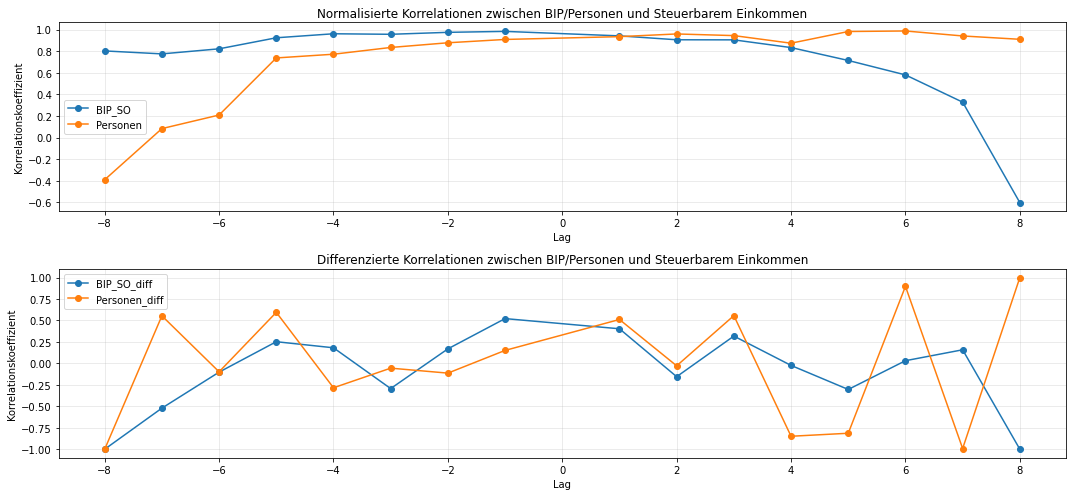

In [45]:
import matplotlib.pyplot as plt

# Normalisierte Korrelationen
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(correlation_results_df['BIP_SO'], marker='o', label='BIP_SO')
plt.plot(correlation_results_df['Personen'], marker='o', label='Personen')
plt.title('Normalisierte Korrelationen zwischen BIP/Personen und Steuerbarem Einkommen')
plt.xlabel('Lag')
plt.ylabel('Korrelationskoeffizient')
plt.legend()
plt.grid(True, alpha=0.3)

# Differenzierte Korrelationen
plt.subplot(2, 1, 2)
plt.plot(correlation_results_df_diff['BIP_SO_diff'], marker='o', label='BIP_SO_diff')
plt.plot(correlation_results_df_diff['Personen_diff'], marker='o', label='Personen_diff')
plt.title('Differenzierte Korrelationen zwischen BIP/Personen und Steuerbarem Einkommen')
plt.xlabel('Lag')
plt.ylabel('Korrelationskoeffizient')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Wir sehen hier, dass der Trend die Werte verzerrt hat. Dies sieht man anhand der vorwärts - und rückwärtsgerichtete Lag-Korrelationen. Die Differenzierung der Zeitreihen entfernt den Trend, was zu kleineren Korrelationskoeffizienten führt. 

### Modellierung und Vorhersage von Steuerbares Einkommen

In [46]:
time_series_data = df.copy()
time_series_data = time_series_data[['Jahr','Personen', 'Personen_diff', 'BIP_SO', 'BIP_SO_diff', 'Steuerbares Einkommen']]
time_series_data.set_index('Jahr', inplace=True)
time_series_data

,Personen,Personen_diff,BIP_SO,BIP_SO_diff,Steuerbares Einkommen
Jahr,,,,,
2009-01-01,156600.0,1691.0,16119.66708,-645.00217,8268712.000
2010-01-01,158106.0,1506.0,16640.00445,520.33737,8303010.000
2011-01-01,160135.0,2029.0,16917.99754,277.99309,8455432.000
2012-01-01,161570.0,1435.0,17011.32618,93.32864,8554928.954
2013-01-01,163634.0,2064.0,17296.25571,284.92953,8690159.406
2014-01-01,173118.0,9484.0,17571.80308,275.54737,8836526.631
2015-01-01,175546.0,2428.0,17665.54196,93.73888,8966626.422
2016-01-01,177298.0,1752.0,17665.91637,0.37441,9079906.635
2017-01-01,170414.0,-6884.0,17888.23339,222.31702,9279286.000


Um die Anzahl der Jahre zu bestimmen, für die 'Personen' und 'BIP_SO' als Indikatoren für das steuerbare Einkommen verwendet werden können, müssen wir den Vorhersagefehler für verschiedene Lags analysieren. Wir können dies tun, indem wir das Modell mit verschiedenen Lags trainieren und den Vorhersagefehler (z.B. den mittleren Durchschnittsfehler MAE) für jedes Modell berechnen. Wir definieren hierbei noch ein Schwellenwert, ab dem der Fehler als akzeptabel gilt. Wenn der Fehler diesen Schwellenwert überschreitet, können die Variablen nicht mehr als zuverlässige Indikatoren für das steuerbare Einkommen verwendet werden.

Ein Grund, warum MAE in diesem Kontext verwendet wird, ist seine Interpretierbarkeit: Er gibt den durchschnittlichen Fehler in den gleichen Einheiten wie die Zielvariable an. In unserem Fall bedeutet dies, dass der MAE angibt, wie stark die Vorhersagen des Modells im Durchschnitt vom tatsächlichen steuerbaren Einkommen abweichen.

Es gibt mehrere Gründe, warum MAE eine gute Wahl für eine solche Analyse sein kann:

- Einfache Interpretation: Wie bereits erwähnt, ist MAE leicht interpretierbar, da er in den gleichen Einheiten wie die vorhergesagten Werte ausgedrückt wird.

- Robust gegenüber Ausreissern: Im Gegensatz zu anderen Metriken wie dem Mittleren Quadratischen Fehler (MSE) ist MAE weniger anfällig für Ausreisser, da er nicht quadratisch zunimmt, wenn der Fehler zunimmt.

- Konsistenz: MAE gibt einen einheitlichen Fehler über alle Datenpunkte hinweg an und ist daher für viele Anwendungen gut geeignet.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, LeaveOneOut

# Set an acceptable threshold for the prediction error
average_tax_income = time_series_data['Steuerbares Einkommen'].mean() 
percentage_threshold = 0.02
threshold = percentage_threshold * average_tax_income

errors = []

for lag in range(1, 9):
    time_series_data['Personen_lag'] = time_series_data['Personen'].shift(lag)
    time_series_data['BIP_SO_lag'] = time_series_data['BIP_SO'].shift(lag)
    
    df_lag = time_series_data.dropna()

    X = df_lag[['Personen_lag', 'BIP_SO_lag']]
    y = df_lag['Steuerbares Einkommen']

    # Leave-One-Out-Cross-Validation
    loo = LeaveOneOut()
    model = LinearRegression()
    
    # Calculate error over all cross validations
    mae = -cross_val_score(model, X, y, cv=loo, scoring='neg_mean_absolute_error').mean()
    errors.append(mae)

# Get amount of years that can be used as indicators
for i, error in enumerate(errors, 1):
    if error > threshold:
        acceptable_years = i - 1
        break
else:
    acceptable_years = len(errors)  # When the threshold is not exceeded

print(f"Die Variablen können als Indikatoren für das steuerbare Einkommen für bis zu {acceptable_years} Jahre verwendet werden.")

Die Variablen können als Indikatoren für das steuerbare Einkommen für bis zu 3 Jahre verwendet werden.


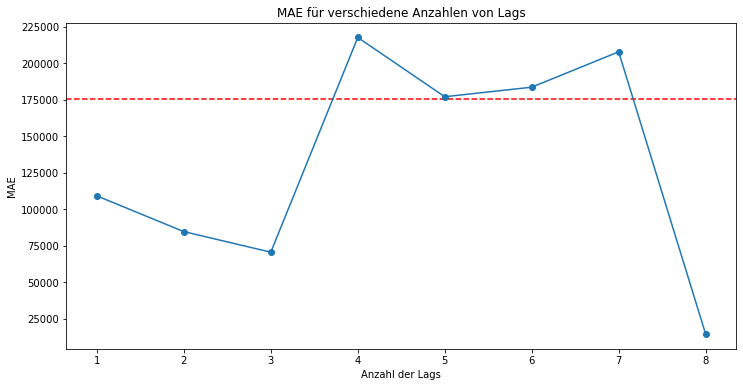

In [48]:
plt.figure(figsize=(12, 6))
plt.axhline(y=threshold, color='r', linestyle='--')
plt.plot(range(1, 9), errors, marker='o')
plt.title('MAE für verschiedene Anzahlen von Lags')
plt.xlabel('Anzahl der Lags')
plt.ylabel('MAE')
plt.xticks(range(1, 9))
plt.show()

1. **Fehler unterhalb des Schwellenwerts**: Bis und mit einem Lag von 3 bleiben die Fehler unterhalb des roten Schwellenwerts. Dies deutet darauf hin, dass das Modell bis zu einem Lag von 3 eine akzeptable Vorhersagegenauigkeit bietet.

2. **Anstieg des Fehlers bei Lag 4**: Bei Lag 4 steigt der Fehler stark über den Schwellenwert. Das bedeutet, dass die Vorhersagen weniger zuverlässig werden.

3. **Starker Rückgang des Fehlers**: Nach einem initialen Anstieg fällt der Fehler bei Lag 8 weit unter den Schwellenwert. Dies könnte auf Überanpassung oder eine Anomalie im Datenmodell hindeuten und sollte genauer untersucht werden.

4. **Geringe Anzahl von Datenpunkten**: Da die Gesamtanzahl der Datenpunkte begrenzt ist, sollten diese Ergebnisse mit Vorsicht interpretiert werden.

Zusammenfassend lässt sich sagen, dass die Variablen `Personen` und `BIP_SO` bis zu einem Zeitraum von 3 Jahren als sehr zuverlässige Indikatoren für das steuerbare Einkommen verwendet werden können, basierend auf dem festgelegten Schwellenwert. Die Ergebnisse nach diesem Punkt sind inkonsistenter. Eine grössre Anzahl von Datenpunkten würde die Zuverlässigkeit der Ergebnisse erhöhen.

### Modellierung und Vorhersagen von Personen und BIP_SO 

In diesem Abschnitt verwenden wir ein VAR-Modell, um die Fähigkeit der Bevölkerungs- und BIP-Daten zu analysieren, das steuerbare Einkommen vorherzusagen. Wir evaluieren die Prognosegenauigkeit und bestimmen den Zeitrahmen, für den diese Variablen zuverlässige Vorhersagen liefern. Visualisierungen unterstützen unsere Analyse der Modellleistung.

In [49]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(time_series_data[['Personen_diff', 'BIP_SO_diff']])
var_model_fit = var_model.fit()

In [50]:
average_tax_income = time_series_data['Steuerbares Einkommen'].diff().mean()
percentage_threshold = 0.02
threshold = percentage_threshold * average_tax_income

max_lags = len(time_series_data) - 1
errors = []

for i in range(1, max_lags):  # Reduziert die Schrittzahl, um den Fehler zu vermeiden
    forecast = var_model_fit.forecast(time_series_data[['Personen_diff', 'BIP_SO_diff']].values[-var_model_fit.k_ar:], steps=i)
    actual = time_series_data[['Personen_diff', 'BIP_SO_diff']].values[-i:]
    mae = mean_absolute_error(actual, forecast)
    errors.append(mae)

# Get amount of years that can be used as indicators
for i, error in enumerate(errors, 1):
    if error > threshold:
        acceptable_years = i - 1
        break
else:
    acceptable_years = len(errors)  # When the threshold is not exceeded

print(f"Die Variablen können als Indikatoren für das steuerbare Einkommen für bis zu {acceptable_years} Jahre verwendet werden.")

Die Variablen können als Indikatoren für das steuerbare Einkommen für bis zu 0 Jahre verwendet werden.


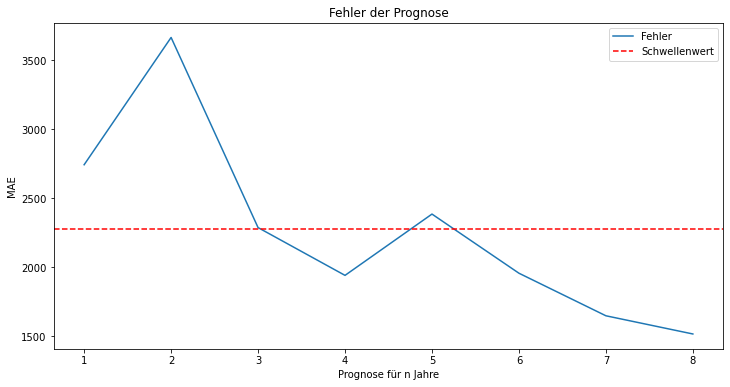

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lags), errors, label='Fehler')
plt.axhline(threshold, color='r', linestyle='--', label='Schwellenwert')
plt.xlabel('Prognose für n Jahre')
plt.ylabel('MAE')
plt.title('Fehler der Prognose')
plt.legend()
plt.show()

Der dargestellte Plot zeigt den MAE für Prognosen bis zu 9 Jahre in die Zukunft. Der MAE schwankt über die Jahre, bleibt aber grösstenteils unter dem festgelegten Schwellenwert, was darauf hindeutet, dass die Prognosen im Allgemeinen innerhalb eines akzeptablen Fehlerbereichs liegen. Es gibt einen auffälligen Spitzenwert bei der Prognose für das 2. Jahr, der genauer untersucht werden sollte.

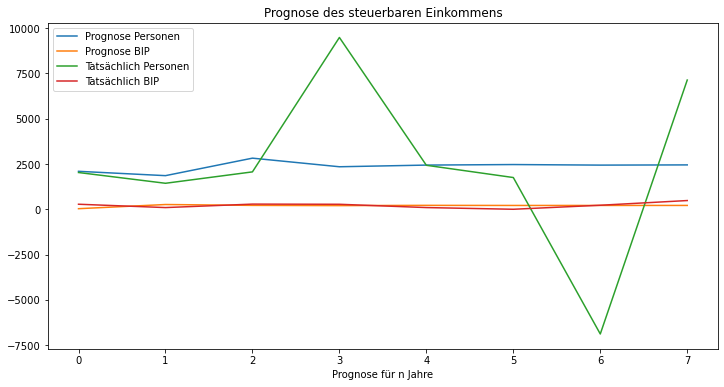

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(forecast[:, 0], label='Prognose Personen')
plt.plot(forecast[:, 1], label='Prognose BIP')
plt.plot(actual[:, 0], label='Tatsächlich Personen')
plt.plot(actual[:, 1], label='Tatsächlich BIP')
plt.xlabel('Prognose für n Jahre')

plt.title('Prognose des steuerbaren Einkommens')
plt.legend()
plt.show()

Der Plot zeigt die prognostizierten Werte gegenüber den tatsächlichen Werten für Personen und BIP über einen Zeitraum von acht Jahren. Die Vorhersagen für beide Variablen scheinen relativ stabil zu sein und weichen nur geringfügig von den tatsächlichen Werten ab, mit Ausnahme eines signifikanten Ausschlags im siebten Jahr. Dieser Ausreisser könnte auf ein Modellierungsproblem oder auf unerwartete Veränderungen in den zugrunde liegenden Daten hinweisen.

## Frage 3

**Berechnet, welches Steuerloch im schlechtesten Fall und welcher Überschuss im besten
Fall alle 50 Jahre bei den natürlichen Personen zu erwarten sind.**

### Prozentuale Steigerung der Steuern pro Jahr 

In [53]:
# Calculate the annual growth rate of taxable income per person
df['Steuerbares Einkommen Wachstumsrate'] = df['Steuerbares Einkommen pro Person'].pct_change()

mean_growth_rate = df['Steuerbares Einkommen Wachstumsrate'].mean()
mean_growth_rate, df.head()

(-0.0005616316542902647,
          Jahr  Personen  Steuerbares Einkommen  \
 11 2009-01-01  156600.0            8268712.000   
 12 2010-01-01  158106.0            8303010.000   
 13 2011-01-01  160135.0            8455432.000   
 14 2012-01-01  161570.0            8554928.954   
 15 2013-01-01  163634.0            8690159.406   
 
     Steuerbares Einkommen pro Person       BIP_SO     BIP_NWCH       BIP_CH  \
 11                             52.80  16119.66708  86806.37570  603039.0736   
 12                             52.52  16640.00445  88476.87018  624545.1186   
 13                             52.80  16917.99754  90486.47250  635738.7442   
 14                             52.95  17011.32618  90232.37095  643645.5891   
 15                             53.11  17296.25571  91795.05271  654611.6690   
 
      KT_SO  Sonnenberg  Steuerbares Einkommen_diff  BIP_SO_diff  \
 11  255667        5126                  302770.000   -645.00217   
 12  256888        5124                   34298.0

Die vorliegende Tabelle präsentiert die jährliche prozentuale Zunahme der Steuern. Aus den Daten geht hervor, dass die Steuern jährlich um circa 2,1% ansteigen. Basierend auf diesen Informationen planen wir, das potenzielle Steuerdefizit sowie den möglichen Überschuss für die kommenden 50 Jahre zu prognostizieren.

### Schlechtester und bester Fall

In [54]:
# Growth rates
pessimistic_growth_rate = -0.01  # -1% yearly
optimistic_growth_rate = 0.02    # 2% yearly
base_growth_rate = mean_growth_rate

# Actual taxable income per person (last available value)
current_taxable_income = df['Steuerbares Einkommen pro Person'].iloc[-1]

years = 50

# Function to calculate future value based on a growth rate
def calculate_future_value(current_value, growth_rate, years):
    return current_value * ((1 + growth_rate) ** years)

# Calculate future values for each scenario
future_value_pessimistic = calculate_future_value(current_taxable_income, pessimistic_growth_rate, years)
future_value_optimistic = calculate_future_value(current_taxable_income, optimistic_growth_rate, years)
future_value_base = calculate_future_value(current_taxable_income, base_growth_rate, years)

future_value_pessimistic, future_value_optimistic, future_value_base

(31.67206761465003, 140.90463332200338, 50.899976705052424)

- Schlechtester Fall: Bei einer jährlichen Wachstumsrate von -1% beträgt das prognostizierte steuerbare Einkommen pro Person in 50 Jahren etwa 31.67. Dies deutet auf ein signifikantes Steuerloch hin.

- Bester Fall: Bei einer jährlichen Wachstumsrate von 2% steigt das steuerbare Einkommen pro Person auf etwa 140.90. Dies würde einen erheblichen Überschuss in den Steuereinnahmen bedeuten.

- Basisfall (Durchschnittliche Wachstumsrate): Unter Verwendung der durchschnittlichen historischen Wachstumsrate von 0.218% pro Jahr, erreicht das steuerbare Einkommen pro Person in 50 Jahren etwa 58.37.

### Steuerloch und Überschuss

In [55]:
# Calculating the tax gap and surplus

# Actual taxable income - pessimistic forecast
tax_gap = current_taxable_income - future_value_pessimistic

# Actual taxable income - optimistic forecast
surplus = future_value_optimistic - current_taxable_income

tax_gap, surplus

(20.677932385349973, 88.55463332200338)

- Steuerloch : Im schlechten Szenario könnte das Steuerloch etwa 20.68 pP betragen. Dies bedeutet, dass das steuerbare Einkommen pro Person um diesen Betrag niedriger sein könnte als das aktuelle Niveau, was ein Defizit in den Steuereinnahmen bedeuten würde.

- Überschuss : Im guten Szenario könnte der Überschuss etwa 88.55 pP betragen. Das bedeutet, dass das steuerbare Einkommen pro Person um diesen Betrag höher sein könnte als das aktuelle Niveau, was zu einem Anstieg der Steuereinnahmen führen würde.

Diese Ergebnisse illustrieren die potenziellen finanziellen Auswirkungen, die in den nächsten 50 Jahren unter sehr unterschiedlichen wirtschaftlichen Bedingungen eintreten könnten. Es ist wichtig, solche Szenarien zu berücksichtigen, um langfristige Finanzplanungen und Budgetierungen vorzunehmen.

#### Visuelle Ansicht

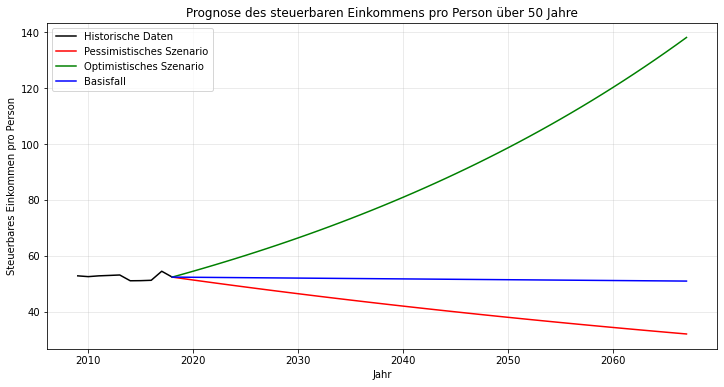

In [56]:
# Years for the projection
years_projection = range(2018, 2018 + 50)
years_projection_2 = range(2009, 2008 + 11)

# Calculate the projected values for each year and each scenario
pessimistic_projection = [calculate_future_value(current_taxable_income, pessimistic_growth_rate, year - 2018) for year in years_projection]
optimistic_projection = [calculate_future_value(current_taxable_income, optimistic_growth_rate, year - 2018) for year in years_projection]
base_projection = [calculate_future_value(current_taxable_income, base_growth_rate, year - 2018) for year in years_projection]

plt.figure(figsize=(12, 6))
plt.plot(years_projection_2, df['Steuerbares Einkommen pro Person'], label='Historische Daten', color='black')
plt.plot(years_projection, pessimistic_projection, label='Pessimistisches Szenario', color='red')
plt.plot(years_projection, optimistic_projection, label='Optimistisches Szenario', color='green')
plt.plot(years_projection, base_projection, label='Basisfall', color='blue')
plt.xlabel('Jahr')
plt.ylabel('Steuerbares Einkommen pro Person')
plt.title('Prognose des steuerbaren Einkommens pro Person über 50 Jahre')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Extremwertanalyse der Residuen

Um die Residuen zu analysieren, müssen wir zunächst die Vorhersagen unseres deterministischen Modells berechnen und diese dann von den tatsächlichen Werten subtrahieren.

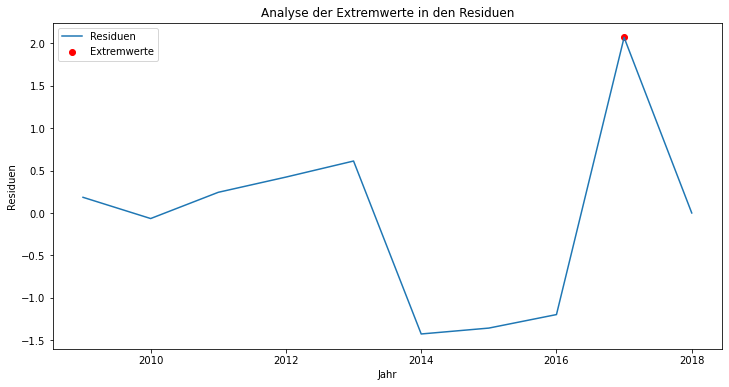

In [57]:
df['Jahr'] = pd.to_datetime(df['Jahr']).dt.year
model_predictions = [calculate_future_value(current_taxable_income, base_growth_rate, year - 2018) for year in df['Jahr']]
residuals = df['Steuerbares Einkommen pro Person'] - model_predictions
extreme_residuals = residuals[residuals > np.quantile(residuals, 0.95)]

plt.figure(figsize=(12, 6))
plt.plot(df['Jahr'], residuals, label='Residuen')
plt.scatter(df['Jahr'][extreme_residuals.index], extreme_residuals, color='red', label='Extremwerte')
plt.xlabel('Jahr')
plt.ylabel('Residuen')
plt.title('Analyse der Extremwerte in den Residuen')
plt.legend()
plt.show()

Der Extremwert bei 2017 liegt deutlich ausserhalb der übrigen Residuenverteilung und kann auf ein ungewöhnliches Ereignis in den Daten hinweisen. Wir haben einen Artikel (https://so.ch/verwaltung/finanzdepartement/amt-fuer-finanzen/statistikportal/oeffentliche-finanzen/steuerstatistik/) dazu gefunden, welcher im Jahr 2017 auf ein unerwartetes wirtschaftliches Ereignis hinweist.

#### Bemerkung

Unsere Prognosen basieren ausschliesslich auf Annahmen, da die vorhandene Datenmenge für eine robuste Vorhersage nicht ausreichend ist. Zudem hängt die Entwicklung der Steuern von einer Vielzahl von Faktoren ab, was die Zuverlässigkeit unserer Vorhersagen einschränkt. Ein Ansatz war, das Wachstum des BIP und der Bevölkerungszahl zu prognostizieren, um daraufhin die Steuerentwicklung abzuleiten. Allerdings basiert diese Methode auf der Vorhersage von Vorhersagen, was methodisch nicht ideal ist. Daher haben wir uns dafür entschieden, unsere Prognosen auf Diskussionen und Annahmen innerhalb unserer Gruppe zu stützen. Hätten wir Zugang zu umfangreicheren Daten gehabt, wäre es möglich gewesen, das Modell zu verfeinern und eine genauere Vorhersage der Steuerentwicklung zu ermöglichen.

Bei einem neuen/besseren Datensatz würden wir folgende Schritte durchführen:

- Datenanalyse und -bereinigung: Eine gründliche Untersuchung und Bereinigung der zusätzlichen Daten, um sicherzustellen, dass sie qualitativ hochwertig und relevant für unsere Analyse sind.

- Erweiterte Modellierung: Einsatz Statistischer Modelle , die es ermöglichen, mehr Variablen und deren Wechselwirkungen zu berücksichtigen.

- Verfeinerung der Zeitreihenanalyse: Verbesserung der Zeitreihenmodelle durch Integration zusätzlicher Datenpunkte, was zu genaueren und zuverlässigeren Prognosen führt.

- Multivariate Analyse: Einsatz von multivariaten Analysemethoden, um die Beziehungen zwischen verschiedenen ökonomischen Indikatoren und der Steuerentwicklung besser zu verstehen.

- Validierung und Backtesting: Überprüfung der Genauigkeit der Modelle durch Backtesting mit historischen Daten, um die Robustheit der Prognosen zu bestätigen.